In [1]:
# Import libraries
import numpy as np
import pandas as pd
import scipy
from scipy import special
from pathlib import Path
import math
import scipy.stats as stat
import matplotlib.pyplot as plt


In [2]:
Nout = 100000 # number of out-of-sample scenarios
Nin = 5000 # number of in-sample scenarios
Ns = 5 # number of idiosyncratic scenarios for each systemic
C = 8 # number of credit states
# Read and parse instrument data
instr_data = np.array(pd.read_csv('instrum_data.csv', header=None))
instr_id = instr_data[:, 0] # ID
driver = instr_data[:, 1] # credit driver
beta = instr_data[:, 2] # beta (sensitivity to credit driver)
recov_rate = instr_data[:, 3] # expected recovery rate
value = instr_data[:, 4] # value
prob = instr_data[:, 5:(5 + C)] # credit-state migration probabilities (default to AAA)
exposure = instr_data[:, 5 + C:5 + 2 * C] # credit-state migration exposures (default to AAA)
retn = instr_data[:, 5 + 2 * C] # market returns
K = instr_data.shape[0] # number of CPs
# Read matrix of correlations for credit drivers
rho = np.array(pd.read_csv('credit_driver_corr.csv', sep='\t', header=None))
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho)
print('======= Credit Risk Model with Credit-State Migrations =======')
print('============== Monte Carlo Scenario Generation ===============')
print(' ')
print(' ')
print(' Number of out-of-sample Monte Carlo scenarios = ' + str(Nout))
print(' Number of in-sample Monte Carlo scenarios = ' + str(Nin))
print(' Number of counterparties = ' + str(K))
print(' ')

======= Credit Risk Model with Credit-State Migrations =======
============== Monte Carlo Scenario Generation ===============
 
 
 Number of out-of-sample Monte Carlo scenarios = 100000
 Number of in-sample Monte Carlo scenarios = 5000
 Number of counterparties = 100
 


In [10]:
# Find credit-state for each counterparty
# 8 = AAA, 7 = AA, 6 = A, 5 = BBB, 4 = BB, 3 = B, 2 = CCC, 1 = default
CS = np.argmax(prob, axis=1) + 1

# Account for default recoveries
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]

# Compute credit-state boundaries
CS_Boundary = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))

# -------- Insert your code here -------- #

N_drivers = len(rho)

y = np.zeros((Nout, N_drivers))

Losses_out = np.zeros((Nout, K))

#filename_save_out = 'scen_out'

#if Path(filename_save_out+'.npz').is_file():
    #Losses_out = scipy.sparse.load_npz(filename_save_out + '.npz')
#else:
    # Generating Scenarios

    # -------- Insert your code here -------- #

    
for s in range(1, Nout + 1):
    nrv = np.random.randn(N_drivers, 1)
    y[s - 1,:] = np.dot(sqrt_rho, nrv).T
    z = np.random.randn(K, 1)

    for k in range(1, K - 1):
        
        credit_driver = int(driver[k - 1])
            
        weight = beta[k - 1] * y[s - 1, credit_driver] + np.sqrt(1 - beta[k - 1] ** 2) * z[k - 1]
        
        temp = np.append(weight, CS_Boundary[k - 1,:])
        
        temp = sorted(temp)
        
        cs_index = np.argwhere(temp == weight)
        
        Losses_out[s - 1, k - 1] = exposure[k - 1, cs_index]

In [12]:
# Normal approximation computed from out-of-sample scenarios
mu_l = np.mean(Losses_out, axis = 0).reshape((K))
var_l = np.cov(Losses_out, rowvar = False) # Losses_out as a sparse matrix

# Compute portfolio weights
v_port = sum(value)  # portfolio value
weight0 = []
weight0.append(value / v_port)   # asset weights (portfolio 1)
weight0.append(np.ones((K)) / K)  # asset weights (portfolio 2)
x0 = []
x0.append((v_port / value) * weight0[0])  # asset units (portfolio 1)
x0.append((v_port / value) * weight0[1])  # asset units (portfolio 2)

# Quantile levels (99%, 99.9%)
alphas = np.array([0.99, 0.999])

VaRout = np.zeros((2, alphas.size))
VaRinN = np.zeros((2, alphas.size))
CVaRout = np.zeros((2, alphas.size))
CVaRinN = np.zeros((2, alphas.size))

for portN in range(2):
    # Compute VaR and CVaR
    for q in range(alphas.size):
        alf = alphas[q]
        # -------- Insert your code here -------- #

        Losses = sorted(np.dot(Losses_out,x0[portN]))
        VaRout[portN, q] = Losses[int(math.ceil(Nout * alf)) -1]
        VaRinN[portN, q] = np.mean(Losses) + stat.norm.ppf(alf) * np.std(Losses)
        CVaRout[portN, q] = (1 / (Nout*(1-alf))) * ((math.ceil(Nout*alf)-Nout*alf) * VaRout[portN,q] + sum(Losses[int(math.ceil(Nout*alf)):]))
        CVaRinN[portN, q] = np.mean(Losses) + (stat.norm.pdf(stat.norm.ppf(alf)) / (1 -alf)) * np.std(Losses)

In [18]:
# Perform 100 trials
N_trials = 100

VaRinMC1 = {}
VaRinMC2 = {}
VaRinN1 = {}
VaRinN2 = {}
CVaRinMC1 = {}
CVaRinMC2 = {}
CVaRinN1 = {}
CVaRinN2 = {}

for portN in range(2):
    for q in range(alphas.size):
        VaRinMC1[portN, q] = np.zeros(N_trials)
        VaRinMC2[portN, q] = np.zeros(N_trials)
        VaRinN1[portN, q] = np.zeros(N_trials)
        VaRinN2[portN, q] = np.zeros(N_trials)
        CVaRinMC1[portN, q] = np.zeros(N_trials)
        CVaRinMC2[portN, q] = np.zeros(N_trials)
        CVaRinN1[portN, q] = np.zeros(N_trials)
        CVaRinN2[portN, q] = np.zeros(N_trials)


for tr in range(1, N_trials + 1):
    # Monte Carlo approximation 1

    # -------- Insert your code here -------- #
    y_inMC1 = np.zeros((int(np.ceil(Nin / Ns)), N_drivers))
    Losses_inMC1 = np.zeros((Nin,K))

    for s in range(1, np.int32(np.ceil(Nin / Ns) + 1)): # systemic scenarios
        # -------- Insert your code here -------- #
        nrv = np.random.randn(N_drivers,1)
        y_inMC1[s-1,:] = np.dot(sqrt_rho,nrv).T
        
        for si in range(1, Ns + 1): # idiosyncratic scenarios for each systemic
            # -------- Insert your code here -------- #
            z_inMC1 = np.random.randn(K,1)

    # Calculate losses for MC1 approximation (5000 x 100)
    # Losses_inMC1
            for k in range(1,K-1): #100
                credit_driver = int(driver[k-1])
                
                w_inMC1 = beta[k-1] * y_inMC1[s-1,credit_driver] + np.sqrt(1 - beta[k-1]**2) * z_inMC1[k-1]
                
                temp_inMC1 = np.append(w_inMC1,CS_Boundary[k-1,:])
                
                temp_inMC1 = sorted(temp_inMC1)
                
                cs_index = np.argwhere(temp_inMC1==w_inMC1)
                
                Losses_inMC1[5*(s-1)+si-1,k-1] = exposure[k-1,cs_index]


    # Monte Carlo approximation 2

    # -------- Insert your code here -------- #
    y_inMC2 = np.zeros((Nin,N_drivers))
    Losses_inMC2 = np.zeros((Nin,K))

    for s in range(1, Nin + 1): # systemic scenarios (1 idiosyncratic scenario for each systemic)
        # -------- Insert your code here -------- #
        nrv = np.random.randn(N_drivers,1)
        y_inMC2[s-1,:] = np.dot(sqrt_rho,nrv).T
        z_inMC2 = np.random.randn(K,1)

    # Calculated losses for MC2 approximation (5000 x 100)
    # Losses_inMC2
        for k in range(1,K - 1):
            credit_driver = int(driver[k-1])
            if credit_driver != 50:
                w_inMC2 = beta[k-1] * y_inMC2[s-1,credit_driver] + np.sqrt(1 - beta[k-1]**2) * z_inMC2[k-1]
                
            buffer_inMC2 = sorted(np.append(w_inMC2,CS_Boundary[k-1,:]))
            
            cs_index = np.argwhere(buffer_inMC2==w_inMC2)
            
            Losses_inMC2[s-1,k-1] = exposure[k-1,cs_index]

In [19]:
    # Compute VaR and CVaR

    for portN in range(2):
        for q in range(alphas.size):
            alf = alphas[q]
            # -------- Insert your code here -------- #

            # Compute portfolio loss
            portf_loss_inMC1 = sorted(np.dot(Losses_inMC1,x0[portN]))
            portf_loss_inMC2 = sorted(np.dot(Losses_inMC2,x0[portN]))
            
            mu_MC1 = np.mean(Losses_inMC1, axis=0).reshape((K))
            var_MC1 = np.cov(Losses_inMC1, rowvar=False)
            
            mu_MC2 = np.mean(Losses_inMC2, axis=0).reshape((K))
            var_MC2 = np.cov(Losses_inMC2, rowvar=False)
            
            # Compute portfolio mean loss mu_p_MC1 and portfolio standard deviation of losses sigma_p_MC1
            mu_p_MC1 = np.dot(mu_MC1,x0[portN])
            sigma_p_MC1 = np.std(portf_loss_inMC1)
            
            # Compute portfolio mean loss mu_p_MC2 and portfolio standard deviation of losses sigma_p_MC2
            mu_p_MC2 = np.dot(mu_MC2,x0[portN])
            sigma_p_MC2 = np.std(portf_loss_inMC2)
            
            # Compute VaR and CVaR for the current trial
            VaRinMC1[portN, q][tr - 1] = portf_loss_inMC1[int(math.ceil(Nin * alf)) -1]
            VaRinMC2[portN, q][tr - 1] = portf_loss_inMC2[int(math.ceil(Nin * alf)) -1]
            
            VaRinN1[portN, q][tr - 1] = mu_p_MC1 + stat.norm.ppf(alf) * sigma_p_MC1
            VaRinN2[portN, q][tr - 1] = mu_p_MC2 + stat.norm.ppf(alf) * sigma_p_MC2
            
            CVaRinMC1[portN, q][tr - 1] = (1 / (Nin*(1-alf))) * ((math.ceil(Nin*alf)-Nin*alf) * VaRinMC1[portN,q][tr - 1] + sum(portf_loss_inMC1[int(math.ceil(Nin*alf)):]))
            CVaRinMC2[portN, q][tr - 1] = (1 / (Nin*(1-alf))) * ((math.ceil(Nin*alf)-Nin*alf) * VaRinMC2[portN,q][tr - 1] + sum(portf_loss_inMC2[int(math.ceil(Nin*alf)):]))
            
            CVaRinN1[portN, q][tr - 1] = mu_p_MC1 + (stat.norm.pdf(stat.norm.ppf(alf)) / (1 -alf)) * sigma_p_MC1
            CVaRinN2[portN, q][tr - 1] = mu_p_MC2 + (stat.norm.pdf(stat.norm.ppf(alf)) / (1 -alf)) * sigma_p_MC2

In [20]:
# Display VaR and CVaR

for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('In-sample No: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('In-sample N1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN1[portN, q]), 100 * alf, np.mean(CVaRinN1[portN, q])))
        print('In-sample N2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f\n' % (
        100 * alf, np.mean(VaRinN2[portN, q]), 100 * alf, np.mean(CVaRinN2[portN, q])))



Portfolio 1:

Out-of-sample: VaR 99.0% = $4701566.21, CVaR 99.0% = $5676533.03
In-sample MC1: VaR 99.0% = $48681.32, CVaR 99.0% = $57042.37
In-sample MC2: VaR 99.0% = $48211.05, CVaR 99.0% = $58006.37
In-sample No: VaR 99.0% = $3589354.16, CVaR 99.0% = $4029740.08
In-sample N1: VaR 99.0% = $36088.44, CVaR 99.0% = $40446.99
In-sample N2: VaR 99.0% = $35809.64, CVaR 99.0% = $40233.52

Out-of-sample: VaR 99.9% = $6870408.93, CVaR 99.9% = $7903268.21
In-sample MC1: VaR 99.9% = $66307.53, CVaR 99.9% = $82035.09
In-sample MC2: VaR 99.9% = $68740.27, CVaR 99.9% = $81204.15
In-sample No: VaR 99.9% = $4582087.59, CVaR 99.9% = $4941888.04
In-sample N1: VaR 99.9% = $45913.64, CVaR 99.9% = $49474.63
In-sample N2: VaR 99.9% = $45782.10, CVaR 99.9% = $49396.46


Portfolio 2:

Out-of-sample: VaR 99.0% = $3517948.80, CVaR 99.0% = $4216773.30
In-sample MC1: VaR 99.0% = $33646.14, CVaR 99.0% = $41535.26
In-sample MC2: VaR 99.0% = $34589.00, CVaR 99.0% = $42628.02
In-sample No: VaR 99.0% = $2865688.12, 

## Portfolio 1

### Figure 1 In-sample MC1 at 99% & 99.9%

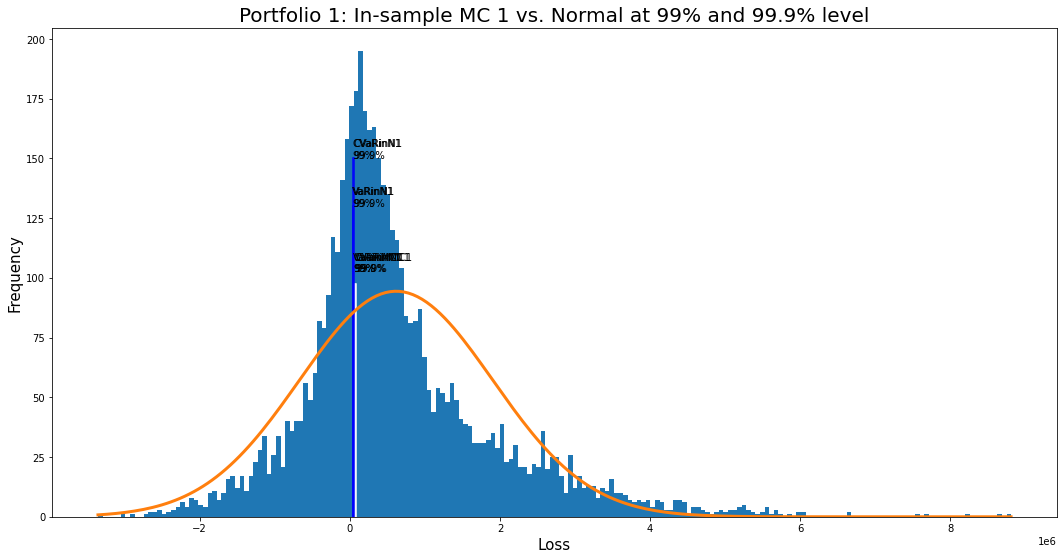

In [43]:
# In-sample Monte Carlo 1 vs. Normal at 99% level and 99.9% level
plt.figure(figsize = (18, 9))
fc, bins, patch = plt.hist(np.dot(Losses_inMC1, x0[0]), 200)
fn = (1 / (np.std(np.dot(Losses_inMC1,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((bins-np.mean(np.dot(Losses_inMC1,x0[0]))) / np.std(np.dot(Losses_inMC1,x0[0]))) ** 2)
fn = fn * sum(fc) / sum(fn)

# Plot non-Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot([np.mean(VaRinMC1[0, 0]), np.mean(VaRinMC1[0, 0])], [0, max(fc)/2], color = 'w')
plt.text(0.95 * np.mean(VaRinMC1[0, 0]), max(fc) / 1.9, 'VaRinMC1\n99%')
plt.plot([np.mean(VaRinMC1[0, 1]), np.mean(VaRinMC1[0, 1])], [0, max(fc)/2], color = 'w')
plt.text(0.95 * np.mean(VaRinMC1[0, 1]), max(fc) / 1.9, 'VaRinMC1\n99.9%')
plt.plot([np.mean(CVaRinMC1[0, 0]), np.mean(CVaRinMC1[0, 0])], [0, max(fc)/2], color = 'w')
plt.text(0.92 * np.mean(CVaRinMC1[0, 0]), max(fc) / 1.9, 'CVaRinMC1\n99%')
plt.plot([np.mean(CVaRinMC1[0, 1]), np.mean(CVaRinMC1[0, 1])], [0, max(fc)/2], color = 'w')
plt.text(0.95 * np.mean(CVaRinMC1[0, 1]), max(fc) / 1.9, 'CVaRinMC1\n99.9%')

# Plot Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot([np.mean(VaRinN1[0, 0]), np.mean(VaRinN1[0, 0])], [0, max(fc)/1.5], color='b')
plt.text(0.95 * np.mean(VaRinN1[0, 0]), max(fc) / 1.5, 'VaRinN1\n99%')
plt.plot([np.mean(VaRinN1[0, 1]), np.mean(VaRinN1[0, 1])], [0, max(fc)/1.5], color='b')
plt.text(0.95 * np.mean(VaRinN1[0, 1]), max(fc) / 1.5, 'VaRinN1\n99.9%')
plt.plot([np.mean(CVaRinN1[0, 0]), np.mean(CVaRinN1[0, 0])], [0, max(fc)/1.3], color='b')
plt.text(0.92 * np.mean(CVaRinN1[0, 0]), max(fc) / 1.3, 'CVaRinN1\n99%')
plt.plot([np.mean(CVaRinN1[0, 1]), np.mean(CVaRinN1[0, 1])], [0, max(fc)/1.3], color='b')
plt.text(0.95 * np.mean(CVaRinN1[0, 1]), max(fc) / 1.3, 'CVaRinN1\n99.9%')

plt.plot(bins, fn, linewidth = 3)
plt.xlabel('Loss', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.title('Portfolio 1: In-sample MC 1 vs. Normal at 99% and 99.9% level', fontsize = 20)
plt.show()

### Figure 2 In-sample MC2 at 99% & 99.9%

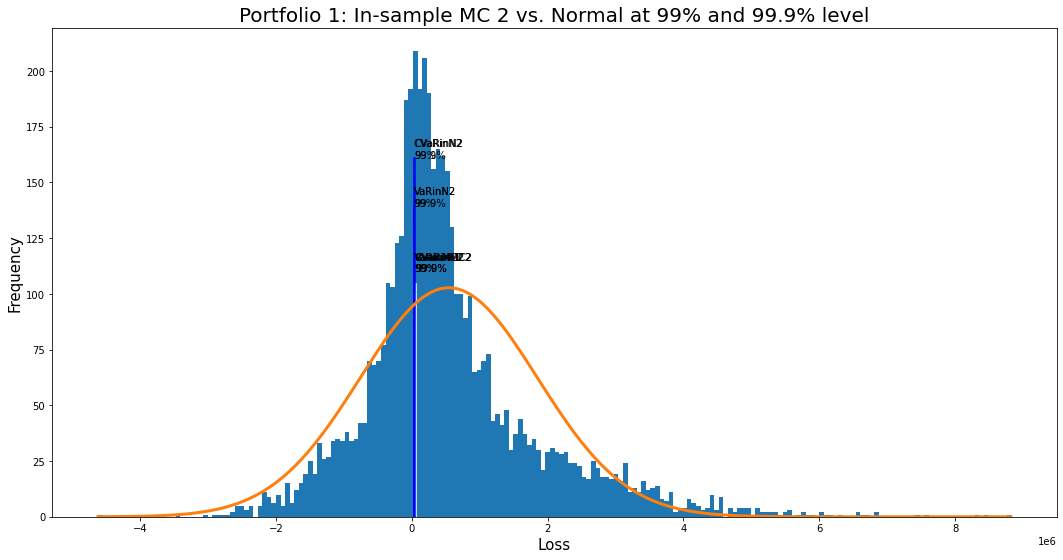

In [61]:
# In-sample Monte Carlo 2 vs. Normal at 99% level and 99.9% level
plt.figure(figsize = (18, 9))
fc, bins, patch = plt.hist(np.dot(Losses_inMC2,x0[0]), 200)
fn = (1 / (np.std(np.dot(Losses_inMC2,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((bins-np.mean(np.dot(Losses_inMC2,x0[0]))) / np.std(np.dot(Losses_inMC2,x0[0]))) ** 2)
fn = fn * sum(fc) / sum(fn)

# Plot non-Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot([np.mean(VaRinMC2[1, 0]), np.mean(VaRinMC2[1, 0])], [0, max(fc)/2], color='w')
plt.text(0.95 * np.mean(VaRinMC2[1, 0]), max(fc) / 1.9, 'VaRinMC2\n99%')
plt.plot([np.mean(VaRinMC2[1, 1]), np.mean(VaRinMC2[1, 1])], [0, max(fc)/2], color='w')
plt.text(0.95 * np.mean(VaRinMC2[1, 1]), max(fc) / 1.9, 'VaRinMC2\n99.9%')
plt.plot([np.mean(CVaRinMC2[1, 0]), np.mean(CVaRinMC2[1, 0])], [0, max(fc)/2], color='w')
plt.text(0.92 * np.mean(CVaRinMC2[1, 0]), max(fc) / 1.9, 'CVaRinMC2\n99%')
plt.plot([np.mean(CVaRinMC2[1, 1]), np.mean(CVaRinMC2[1, 1])], [0, max(fc)/2], color='w')
plt.text(0.95 * np.mean(CVaRinMC2[1, 1]), max(fc) / 1.9, 'CVaRinMC2\n99.9%')

# Plot Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot([np.mean(VaRinN2[1, 0]), np.mean(VaRinN2[1, 0])], [0, max(fc)/1.5], color='b')
plt.text(0.95 * np.mean(VaRinN2[1, 0]), max(fc) / 1.5, 'VaRinN2\n99%')
plt.plot([np.mean(VaRinN2[1, 1]), np.mean(VaRinN2[1, 1])], [0, max(fc)/1.5], color='b')
plt.text(0.95 * np.mean(VaRinN2[1, 1]), max(fc) / 1.5, 'VaRinN2\n99.9%')
plt.plot([np.mean(CVaRinN2[1, 0]), np.mean(CVaRinN2[1, 0])], [0, max(fc)/1.3], color='b')
plt.text(0.92 * np.mean(CVaRinN2[1, 0]), max(fc) / 1.3, 'CVaRinN2\n99%')
plt.plot([np.mean(CVaRinN2[1, 1]), np.mean(CVaRinN2[1, 1])], [0, max(fc)/1.3], color='b')
plt.text(0.95 * np.mean(CVaRinN2[1, 1]), max(fc) / 1.3, 'CVaRinN2\n99.9%')

plt.plot(bins, fn, linewidth = 3)
plt.xlabel('Loss', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.title('Portfolio 1: In-sample MC 2 vs. Normal at 99% and 99.9% level', fontsize = 20)
plt.show()

### Figure 3 Out-of-sample vs Normal at 99% & 99.9%

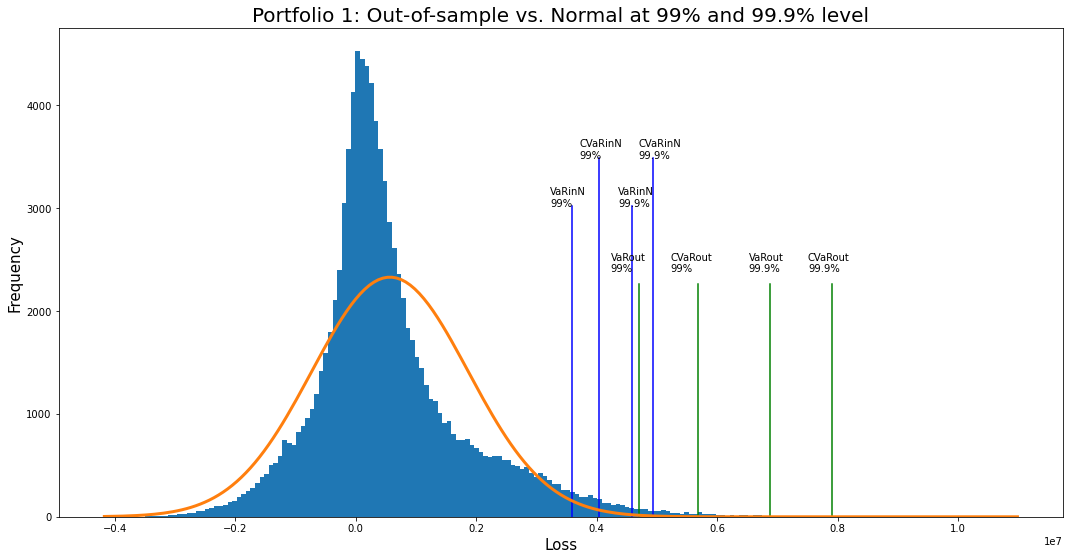

In [52]:
# Out-of-sample vs. Normal at 99% level and 99.9% level
plt.figure(figsize = (18, 9))
fc, bins, patch = plt.hist(np.dot(Losses_out,x0[0]), 200)
fn = (1 / (np.std(np.dot(Losses_out,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((bins-np.mean(np.dot(Losses_out,x0[0]))) / np.std(np.dot(Losses_out,x0[0]))) ** 2)
fn = fn * sum(fc) / sum(fn)

# Plot non-Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot([VaRout[0,0], VaRout[0,0]], [0, max(fc)/2], color='g')
plt.text(0.90 * VaRout[0,0], max(fc) / 1.9, 'VaRout\n99%')
plt.plot([VaRout[0,1], VaRout[0,1]], [0, max(fc)/2], color='g')
plt.text(0.95 * VaRout[0,1], max(fc) / 1.9, 'VaRout\n99.9%')
plt.plot([CVaRout[0,0], CVaRout[0,0]], [0, max(fc)/2], color='g')
plt.text(0.92 * CVaRout[0,0], max(fc) / 1.9, 'CVaRout\n99%')
plt.plot([CVaRout[0,1], CVaRout[0,1]], [0, max(fc)/2], color='g')
plt.text(0.95 * CVaRout[0,1], max(fc) / 1.9, 'CVaRout\n99.9%')

# Plot Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot([VaRinN[0,0], VaRinN[0,0]], [0, max(fc)/1.5], color='b')
plt.text(0.90 * VaRinN[0,0], max(fc) / 1.5, 'VaRinN\n99%')
plt.plot([VaRinN[0,1], VaRinN[0,1]], [0, max(fc)/1.5], color='b')
plt.text(0.95 * VaRinN[0,1], max(fc) / 1.5, 'VaRinN\n99.9%')
plt.plot([CVaRinN[0,0], CVaRinN[0,0]], [0, max(fc)/1.3], color='b')
plt.text(0.92 * CVaRinN[0,0], max(fc) / 1.3, 'CVaRinN\n99%')
plt.plot([CVaRinN[0,1], CVaRinN[0,1]], [0, max(fc)/1.3], color='b')
plt.text(0.95 * CVaRinN[0,1], max(fc) / 1.3, 'CVaRinN\n99.9%')

plt.plot(bins, fn, linewidth = 3)
plt.xlabel('Loss', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.title('Portfolio 1: Out-of-sample vs. Normal at 99% and 99.9% level', fontsize = 20)
plt.show()

## Portfolio 2

### Figure 4 In-sample MC1 at 99% & 99.9%¶

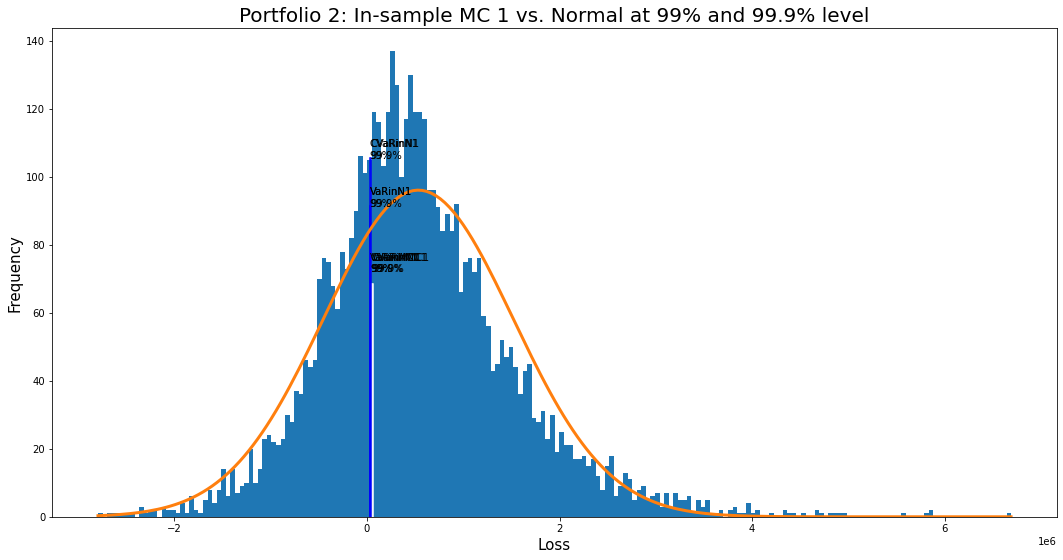

In [62]:
# In-sample Monte Carlo 1 vs. Normal at 99% level and 99.9% level
plt.figure(figsize = (18, 9))
fc, bins, patch = plt.hist(np.dot(Losses_inMC1,x0[1]), 200)
fn = (1 / (np.std(np.dot(Losses_inMC1,x0[1])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((bins-np.mean(np.dot(Losses_inMC1,x0[1]))) / np.std(np.dot(Losses_inMC1,x0[1]))) ** 2)
fn = fn * sum(fc) / sum(fn)

# Plot non-Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot([np.mean(VaRinMC1[1, 0]), np.mean(VaRinMC1[1, 0])], [0, max(fc)/2], color='w')
plt.text(0.95 * np.mean(VaRinMC1[1, 0]), max(fc) / 1.9, 'VaRinMC1\n99%')
plt.plot([np.mean(VaRinMC1[1, 1]), np.mean(VaRinMC1[1, 1])], [0, max(fc)/2], color='w')
plt.text(0.95 * np.mean(VaRinMC1[1, 1]), max(fc) / 1.9, 'VaRinMC1\n99.9%')
plt.plot([np.mean(CVaRinMC1[1, 0]), np.mean(CVaRinMC1[1, 0])], [0, max(fc)/2], color='w')
plt.text(0.92 * np.mean(CVaRinMC1[1, 0]), max(fc) / 1.9, 'CVaRinMC1\n99%')
plt.plot([np.mean(CVaRinMC1[1, 1]), np.mean(CVaRinMC1[1, 1])], [0, max(fc)/2], color='w')
plt.text(0.95 * np.mean(CVaRinMC1[1, 1]), max(fc) / 1.9, 'CVaRinMC1\n99.9%')

# Plot Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot([np.mean(VaRinN1[1, 0]), np.mean(VaRinN1[1, 0])], [0, max(fc)/1.5], color='b')
plt.text(0.95 * np.mean(VaRinN1[1, 0]), max(fc) / 1.5, 'VaRinN1\n99%')
plt.plot([np.mean(VaRinN1[1, 1]), np.mean(VaRinN1[1, 1])], [0, max(fc)/1.5], color='b')
plt.text(0.95 * np.mean(VaRinN1[1, 1]), max(fc) / 1.5, 'VaRinN1\n99.9%')
plt.plot([np.mean(CVaRinN1[1, 0]), np.mean(CVaRinN1[1, 0])], [0, max(fc)/1.3], color='b')
plt.text(0.92 * np.mean(CVaRinN1[1, 0]), max(fc) / 1.3, 'CVaRinN1\n99%')
plt.plot([np.mean(CVaRinN1[1, 1]), np.mean(CVaRinN1[1, 1])], [0, max(fc)/1.3], color='b')
plt.text(0.95 * np.mean(CVaRinN1[1, 1]), max(fc) / 1.3, 'CVaRinN1\n99.9%')

plt.plot(bins, fn, linewidth = 3)
plt.xlabel('Loss', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.title('Portfolio 2: In-sample MC 1 vs. Normal at 99% and 99.9% level', fontsize = 20)
plt.show()

### Figure 5 In-sample MC2 at 99% & 99.9%¶¶

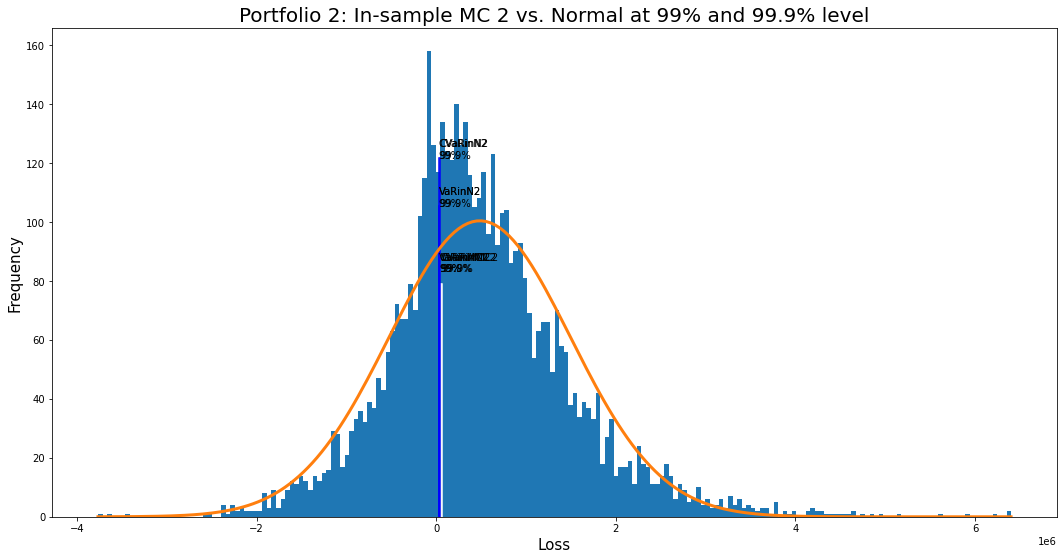

In [63]:
# In-sample Monte Carlo 2 vs. Normal at 99% level and 99.9% level
plt.figure(figsize = (18, 9))
fc, bins, patch = plt.hist(np.dot(Losses_inMC2,x0[1]), 200)
fn = (1 / (np.std(np.dot(Losses_inMC2,x0[1])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((bins-np.mean(np.dot(Losses_inMC2,x0[1]))) / np.std(np.dot(Losses_inMC2,x0[1]))) ** 2)
fn = fn * sum(fc) / sum(fn)

# Plot non-Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot([np.mean(VaRinMC2[1, 0]), np.mean(VaRinMC2[1, 0])], [0, max(fc)/2], color='w')
plt.text(0.95 * np.mean(VaRinMC2[1, 0]), max(fc) / 1.9, 'VaRinMC2\n99%')
plt.plot([np.mean(VaRinMC2[1, 1]), np.mean(VaRinMC2[1, 1])], [0, max(fc)/2], color='w')
plt.text(0.95 * np.mean(VaRinMC2[1, 1]), max(fc) / 1.9, 'VaRinMC2\n99.9%')
plt.plot([np.mean(CVaRinMC2[1, 0]), np.mean(CVaRinMC2[1, 0])], [0, max(fc)/2], color='w')
plt.text(0.92 * np.mean(CVaRinMC2[1, 0]), max(fc) / 1.9, 'CVaRinMC2\n99%')
plt.plot([np.mean(CVaRinMC2[1, 1]), np.mean(CVaRinMC2[1, 1])], [0, max(fc)/2], color='w')
plt.text(0.95 * np.mean(CVaRinMC2[1, 1]), max(fc) / 1.9, 'CVaRinMC2\n99.9%')

# Plot Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot([np.mean(VaRinN2[1, 0]), np.mean(VaRinN2[1, 0])], [0, max(fc)/1.5], color='b')
plt.text(0.95 * np.mean(VaRinN2[1, 0]), max(fc) / 1.5, 'VaRinN2\n99%')
plt.plot([np.mean(VaRinN2[1, 1]), np.mean(VaRinN2[1, 1])], [0, max(fc)/1.5], color='b')
plt.text(0.95 * np.mean(VaRinN2[1, 1]), max(fc) / 1.5, 'VaRinN2\n99.9%')
plt.plot([np.mean(CVaRinN2[1, 0]), np.mean(CVaRinN2[1, 0])], [0, max(fc)/1.3], color='b')
plt.text(0.92 * np.mean(CVaRinN2[1, 0]), max(fc) / 1.3, 'CVaRinN2\n99%')
plt.plot([np.mean(CVaRinN2[1, 1]), np.mean(CVaRinN2[1, 1])], [0, max(fc)/1.3], color='b')
plt.text(0.95 * np.mean(CVaRinN2[1, 1]), max(fc) / 1.3, 'CVaRinN2\n99.9%')

plt.plot(bins, fn, linewidth = 3)
plt.xlabel('Loss', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.title('Portfolio 2: In-sample MC 2 vs. Normal at 99% and 99.9% level', fontsize = 20)
plt.show()

### Figure 6 Out-of-sample vs Normal at 99% & 99.9%

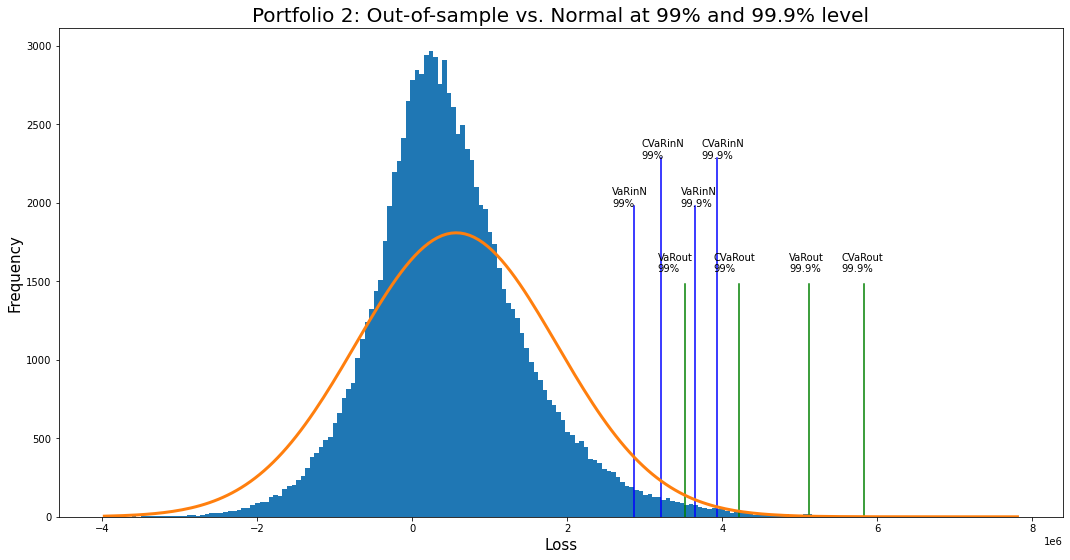

In [51]:
# Out-of-sample vs. Normal at 99% level and 99.9% level
plt.figure(figsize = (18, 9))
fc, bins, patch = plt.hist(np.dot(Losses_out,x0[1]), 200)
fn = (1 / (np.std(np.dot(Losses_out,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((bins-np.mean(np.dot(Losses_out,x0[0]))) / np.std(np.dot(Losses_out,x0[0]))) ** 2)
fn = fn * sum(fc) / sum(fn)

# Plot non-Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot([VaRout[1,0], VaRout[1,0]], [0, max(fc)/2], color='g')
plt.text(0.90 * VaRout[1,0], max(fc) / 1.9, 'VaRout\n99%')
plt.plot([VaRout[1,1], VaRout[1,1]], [0, max(fc)/2], color='g')
plt.text(0.95 * VaRout[1,1], max(fc) / 1.9, 'VaRout\n99.9%')
plt.plot([CVaRout[1,0], CVaRout[1,0]], [0, max(fc)/2], color='g')
plt.text(0.92 * CVaRout[1,0], max(fc) / 1.9, 'CVaRout\n99%')
plt.plot([CVaRout[1,1], CVaRout[1,1]], [0, max(fc)/2], color='g')
plt.text(0.95 * CVaRout[1,1], max(fc) / 1.9, 'CVaRout\n99.9%')

# Plot Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot([VaRinN[1,0], VaRinN[1,0]], [0, max(fc)/1.5], color='b')
plt.text(0.90 * VaRinN[1,0], max(fc) / 1.5, 'VaRinN\n99%')
plt.plot([VaRinN[1,1], VaRinN[1,1]], [0, max(fc)/1.5], color='b')
plt.text(0.95 * VaRinN[1,1], max(fc) / 1.5, 'VaRinN\n99.9%')
plt.plot([CVaRinN[1,0], CVaRinN[1,0]], [0, max(fc)/1.3], color='b')
plt.text(0.92 * CVaRinN[1,0], max(fc) / 1.3, 'CVaRinN\n99%')
plt.plot([CVaRinN[1,1], CVaRinN[1,1]], [0, max(fc)/1.3], color='b')
plt.text(0.95 * CVaRinN[1,1], max(fc) / 1.3, 'CVaRinN\n99.9%')

plt.plot(bins, fn, linewidth = 3)
plt.xlabel('Loss', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.title('Portfolio 2: Out-of-sample vs. Normal at 99% and 99.9% level', fontsize = 20)
plt.show()

In [64]:
# Calculate Mean and SD for portfolio 1
# mean and standard deviation of out-sample
mo1 = np.mean(sorted(np.dot(Losses_out,x0[0])))
so1 = np.std(sorted(np.dot(Losses_out,x0[0])))
# mean and standard deviation of in-sample MC1
mcm1_1 = np.dot(mu_MC1,x0[0])
sdm1_1 = np.std(sorted(np.dot(Losses_inMC1,x0[0])))
# mean and standard deviation of in-sample MC2
mcm2_1 = np.dot(mu_MC2,x0[0])
sdm2_1 = np.std(sorted(np.dot(Losses_inMC2,x0[0])))

In [65]:
# Calculate Mean and SD for portfolio 2
# mean and standard deviation of out-sample
mo2 = np.mean(sorted(np.dot(Losses_out,x0[1])))
so2 = np.std(sorted(np.dot(Losses_out,x0[1])))
# mean and standard deviation of in-sample MC1
mcm1_2 = np.dot(mu_MC1,x0[1])
sdm1_2 = np.std(sorted(np.dot(Losses_inMC1,x0[1])))
# mean and standard deviation of in-sample MC2
mcm2_2 = np.dot(mu_MC2,x0[1])
sdm2_2 = np.std(sorted(np.dot(Losses_inMC2,x0[1])))

pd.options.display.float_format = '${:,.2f}'.format

In [66]:
# visulization of results
pd.DataFrame([[mo1, so1], [mcm1_1,sdm1_1],
              [mcm2_1,sdm2_1],[mo2, so2],
              [mcm1_2,sdm1_2],[mcm2_2,sdm2_2]],
             index = ['Portfolio 1, Out-of-sample','Portfolio 1, MC1','Portfolio 1, MC2','Portfolio 2, Out-of-sample','Portfolio 2, MC1','Portfolio 2, MC2',],
             columns = ['Mean','Standard Deviation'])

,Mean,Standard Deviation
"Portfolio 1, Out-of-sample","$566,065.31","$1,299,585.88"
"Portfolio 1, MC1","$616,657.61","$1,286,216.19"
"Portfolio 1, MC2","$543,931.48","$1,305,493.65"
"Portfolio 2, Out-of-sample","$496,461.98","$1,018,431.58"
"Portfolio 2, MC1","$532,791.99","$984,971.16"
"Portfolio 2, MC2","$485,530.53","$1,010,078.99"


In [67]:
# Sampling error for portfolio 1
se1_V99_1 = abs(np.mean(VaRinMC1[0, 0])-VaRout[0, 0])/VaRout[0, 0]*100
se1_CV99_1 = abs(np.mean(CVaRinMC1[0, 0])-CVaRout[0, 0])/VaRout[0, 0]*100
se1_V99_2 = abs(np.mean(VaRinMC2[0, 0])-VaRout[0, 0])/VaRout[0, 0]*100
se1_CV99_2 = abs(np.mean(CVaRinMC2[0, 0])-CVaRout[0, 0])/VaRout[0, 0]*100

se1_V999_1 = abs(np.mean(VaRinMC1[0, 1])-VaRout[0, 1])/VaRout[0, 1]*100
se1_CV999_1 = abs(np.mean(CVaRinMC1[0, 1])-CVaRout[0, 1])/VaRout[0, 1]*100
se1_V999_2 = abs(np.mean(VaRinMC2[0, 1])-VaRout[0, 1])/VaRout[0, 1]*100
se1_CV999_2 = abs(np.mean(CVaRinMC2[0, 1])-CVaRout[0, 1])/VaRout[0, 1]*100

# Sampling error for portfolio 1
se2_V99_1 = abs(np.mean(VaRinMC1[1, 0])-VaRout[1, 0])/VaRout[1, 0]*100
se2_CV99_1 = abs(np.mean(CVaRinMC1[1, 0])-CVaRout[1, 0])/VaRout[1, 0]*100
se2_V99_2 = abs(np.mean(VaRinMC2[1, 0])-VaRout[1, 0])/VaRout[1, 0]*100
se2_CV99_2 = abs(np.mean(CVaRinMC2[1, 0])-CVaRout[1, 0])/VaRout[1, 0]*100

se2_V999_1 = abs(np.mean(VaRinMC1[1, 1])-VaRout[1, 1])/VaRout[1, 1]*100
se2_CV999_1 = abs(np.mean(CVaRinMC1[1, 1])-CVaRout[1, 1])/VaRout[1, 1]*100
se2_V999_2 = abs(np.mean(VaRinMC2[1, 1])-VaRout[1, 1])/VaRout[1, 1]*100
se2_CV999_2 = abs(np.mean(CVaRinMC2[1, 1])-CVaRout[1, 1])/VaRout[1, 1]*100

In [68]:
#visulization of results
df_sampling = pd.DataFrame([se1_V99_1,se1_CV99_1,se1_V99_2,se1_CV99_2,se1_V999_1,se1_CV999_1,se1_V999_2,se1_CV999_2,
              se2_V99_1,se2_CV99_1,se2_V99_2,se2_CV99_2,se2_V999_1,se2_CV999_1,se2_V999_2,se2_CV999_2],
             index=['99% VaR, MC1, Portfolio 1','99% CVaR, MC1, Portfolio 1','99% VaR, MC2, Portfolio 1','99% CVaR, MC2, Portfolio 1',
                    '99.9% VaR, MC1, Portfolio 1','99.9% CVaR, MC1, Portfolio 1','99.9% VaR, MC2, Portfolio 1','99.9% CVaR, MC2, Portfolio 1',
                    '99% VaR, MC1, Portfolio 2','99% CVaR, MC1, Portfolio 2','99% VaR, MC2, Portfolio 2','99% CVaR, MC2, Portfolio 2',
                    '99.9% VaR, MC1, Portfolio 2','99.9% CVaR, MC1, Portfolio 2','99.9% VaR, MC2, Portfolio 2','99.9% CVaR, MC2, Portfolio 2'],
             columns=['Sampling Error (% difference)'])
df_sampling['Sampling Error (% difference)'] = df_sampling['Sampling Error (% difference)'].map("{:,.2f}%".format)
df_sampling

,Sampling Error (% difference)
"99% VaR, MC1, Portfolio 1",98.96%
"99% CVaR, MC1, Portfolio 1",119.52%
"99% VaR, MC2, Portfolio 1",98.97%
"99% CVaR, MC2, Portfolio 1",119.50%
"99.9% VaR, MC1, Portfolio 1",99.03%
"99.9% CVaR, MC1, Portfolio 1",113.84%
"99.9% VaR, MC2, Portfolio 1",99.00%
"99.9% CVaR, MC2, Portfolio 1",113.85%
"99% VaR, MC1, Portfolio 2",99.04%
"99% CVaR, MC1, Portfolio 2",118.68%


In [69]:
# Model error for portfolio 1
me1_V99_1 = abs(np.mean(VaRinN1[0, 0])-VaRout[0, 0])/VaRout[0, 0]*100
me1_CV99_1 = abs(np.mean(CVaRinN1[0, 0])-CVaRout[0, 0])/VaRout[0, 0]*100
me1_V99_2 = abs(np.mean(VaRinN2[0, 0])-VaRout[0, 0])/VaRout[0, 0]*100
me1_CV99_2 = abs(np.mean(CVaRinN2[0, 0])-CVaRout[0, 0])/VaRout[0, 0]*100

me1_V999_1 = abs(np.mean(VaRinN1[0, 1])-VaRout[0, 1])/VaRout[0, 1]*100
me1_CV999_1 = abs(np.mean(CVaRinN1[0, 1])-CVaRout[0, 1])/VaRout[0, 1]*100
me1_V999_2 = abs(np.mean(VaRinN2[0, 1])-VaRout[0, 1])/VaRout[0, 1]*100
me1_CV999_2 = abs(np.mean(CVaRinN2[0, 1])-CVaRout[0, 1])/VaRout[0, 1]*100

# Model error for portfolio 2
me2_V99_1 = abs(np.mean(VaRinN1[1, 0])-VaRout[1, 0])/VaRout[1, 0]*100
me2_CV99_1 = abs(np.mean(CVaRinN1[1, 0])-CVaRout[1, 0])/VaRout[1, 0]*100
me2_V99_2 = abs(np.mean(VaRinN2[1, 0])-VaRout[1, 0])/VaRout[1, 0]*100
me2_CV99_2 = abs(np.mean(CVaRinN2[1, 0])-CVaRout[1, 0])/VaRout[1, 0]*100

me2_V999_1 = abs(np.mean(VaRinN1[1, 1])-VaRout[1, 1])/VaRout[1, 1]*100
me2_CV999_1 = abs(np.mean(CVaRinN1[1, 1])-CVaRout[1, 1])/VaRout[1, 1]*100
me2_V999_2 = abs(np.mean(VaRinN2[1, 1])-VaRout[1, 1])/VaRout[1, 1]*100
me2_CV999_2 = abs(np.mean(CVaRinN2[1, 1])-CVaRout[1, 1])/VaRout[1, 1]*100


In [71]:
#visulization of results
df_model = pd.DataFrame([me1_V99_1,me1_CV99_1,me1_V99_2,me1_CV99_2,me1_V999_1,me1_CV999_1,me1_V999_2,me1_CV999_2,
                            me2_V99_1,me2_CV99_1,me2_V99_2,me2_CV99_2,me2_V999_1,me2_CV999_1,me2_V999_2,me2_CV999_2],
             index=['99% VaR, N1, Portfolio 1','99% CVaR, N1, Portfolio 1','99% VaR, N2, Portfolio 1','99% CVaR, N2, Portfolio 1',
                    '99.9% VaR, N1, Portfolio 1','99.9% CVaR, N1, Portfolio 1','99.9% VaR, N2, Portfolio 1','99.9% CVaR, N2, Portfolio 1',
                    '99% VaR, N1, Portfolio 2','99% CVaR, N1, Portfolio 2','99% VaR, N2, Portfolio 2','99% CVaR, N2, Portfolio 2',
                    '99.9% VaR, N1, Portfolio 2','99.9% CVaR, N1, Portfolio 2','99.9% VaR, N2, Portfolio 2','99.9% CVaR, N2, Portfolio 2'],
             columns=['Model Error (% difference)'])
df_model['Model Error (% difference)'] = df_model['Model Error (% difference)'].map("{:,.2f}%".format)
df_model

,Model Error (% difference)
"99% VaR, N1, Portfolio 1",99.23%
"99% CVaR, N1, Portfolio 1",119.88%
"99% VaR, N2, Portfolio 1",99.24%
"99% CVaR, N2, Portfolio 1",119.88%
"99.9% VaR, N1, Portfolio 1",99.33%
"99.9% CVaR, N1, Portfolio 1",114.31%
"99.9% VaR, N2, Portfolio 1",99.33%
"99.9% CVaR, N2, Portfolio 1",114.31%
"99% VaR, N1, Portfolio 2",99.20%
"99% CVaR, N1, Portfolio 2",118.97%
